In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
import torch as th
import torch.jit as jit
import numpy as np
from torch import optim
from torch import nn
from dynrn.rnntasks import DriscollTasks, itiexp
import dynrn.basic_rnns as rnns
import scipy.stats
from scipy.stats import uniform, norm
from datetime import datetime
from mplutil import util as vu
import matplotlib.pyplot as plt
import scipy.stats
from pathlib import Path
import tqdm
import joblib as jl
import time
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
t20 = lambda x: getc(f"seaborn:tab20{x}")
colors, plotter = styles.init_plt(
    '../plots/notebook/driscoll-rnns',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

In [4]:
# cuda setup
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(device.type)

cpu


### MemoryPro

In [5]:
task_kws = dict(
    iti=itiexp(6, 10),
    context=itiexp(6, 10),
    stim=itiexp(6, 10),
    memory=itiexp(6, 10),
    response=itiexp(6, 10),
    magnitude=uniform(1, 1),
    angle=uniform(0, 0.78),
    angle_noise=norm(0, 0.),
    flag_noise=norm(0, 0.1),
)

x, y, periods = DriscollTasks.memorypro(
    session_length=500,
    n_sessions=70,
    **task_kws
)
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

icolors = [getc("k"), getc("grey"), t20("b:17"), t20("b:19")]
ocolors = [t20("c:0"), t20("c:2")]

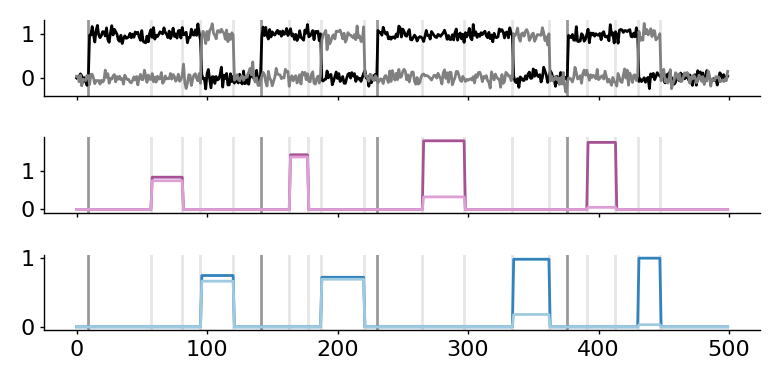

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(4, 2), sharex = True)

session = 2
ax[0].plot(x.numpy()[session, :, 0], color = icolors[0])
ax[0].plot(x.numpy()[session, :, 1], color = icolors[1])
ax[1].plot(x.numpy()[session, :, 2], color = icolors[2])
ax[1].plot(x.numpy()[session, :, 3], color = icolors[3])
ax[2].plot(y.numpy()[session, :, 0], color = ocolors[0])
ax[2].plot(y.numpy()[session, :, 1], color = ocolors[1])
for t in np.where(np.diff(periods[session]) != 0)[0]:
    for a in ax[[0, 1, 2]]:
        a.axvline(t, color='.6' if periods[session, t] == 0 else '.9', lw = 1, zorder = -1)

# ax[0].set_xlim(0, 30)
plotter.finalize(fig, None)

In [11]:
out_dir = Path("/n/holylabs/LABS/bsabatini_lab/Users/kfox/loop/dynrn/tasks")
jl.dump(task_kws, out_dir / 'memorypro-long.jl')

['/n/holylabs/LABS/bsabatini_lab/Users/kfox/loop/dynrn/tasks/memorypro-long.jl']

##### rnn to perform task

In [12]:
class BasicRNN(rnns.DynamicalRNN):
    def __init__(
        self,
        nx=4,
        nh=10,
        ny=None,
        alpha=0.1,
        act=nn.Sigmoid(),
        h_bias=0,
        w_scale=1,
        act_ofs=0,
        bias = False,
    ):
        """
        Approximate dynamical RNN with negative weights.

        Parameters
        ----------
        alpha : float
            Step size divided by time constant, or equivalently a coefficient
            for convex combination of (in [0, 1]) $h_{t-1}$ and $f(h_{t-1})$ in
            the hidden state update rule, with `alpha` equal to 1 corresponding
            to a no-memory update.
        """
        nn.Module.__init__(self)
        rnns.init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)

        self.i2h = nn.Linear(self.nx, self.nh, bias=bias)
        self.h2h = nn.Linear(self.nh, self.nh, bias=bias)
        self.h2y = nn.Linear(self.nh, self.ny, bias=bias)

    def forward(self, x, h):
        I = self.w_scale * self.h2h(h) + self.i2h(x)
        fh = self.act(I + self.h_bias) + self.act_ofs
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(h_new)
        return y, h_new

SyntaxError: incomplete input (1154173534.py, line 41)

In [16]:
th.manual_seed(0)
rnn = BasicRNN(
    x.shape[-1], 1024, y.shape[-1], alpha=1, act=nn.Softplus(), bias=True
)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)

rnn.to(device)

opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats = rnns.fit_rnn(rnn, x.to(device), y.to(device), opt, n_steps=10000, return_h = False)

100%|██████████| 10000/10000 [06:47<00:00, 24.56it/s]


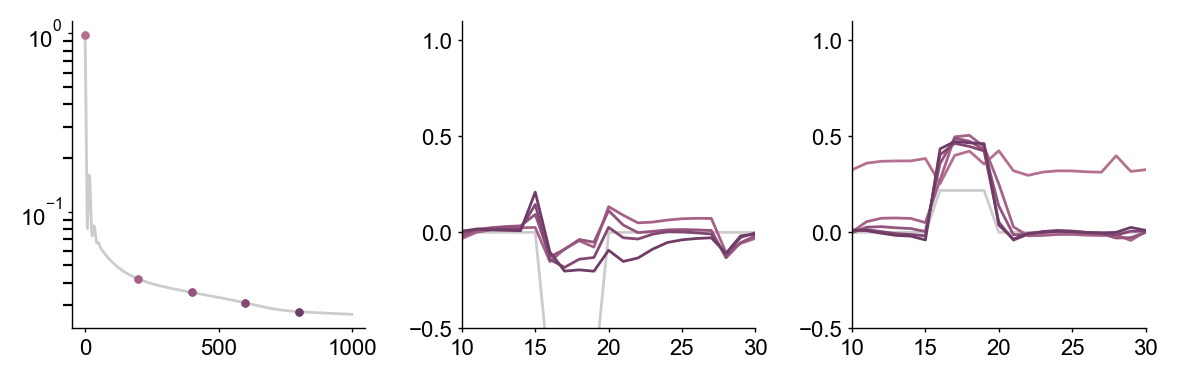

In [112]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y)
for a in ax[1:]:
    a.set_xlim(10, 30)
    a.set_ylim(-0.5, 1.1)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

In [30]:
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=3e-5)
losses, yhats = rnns.fit_rnn(rnn, x.to(device), y.to(device), opt, n_steps=1000, return_h = False)

100%|██████████| 1000/1000 [01:43<00:00,  9.70it/s]


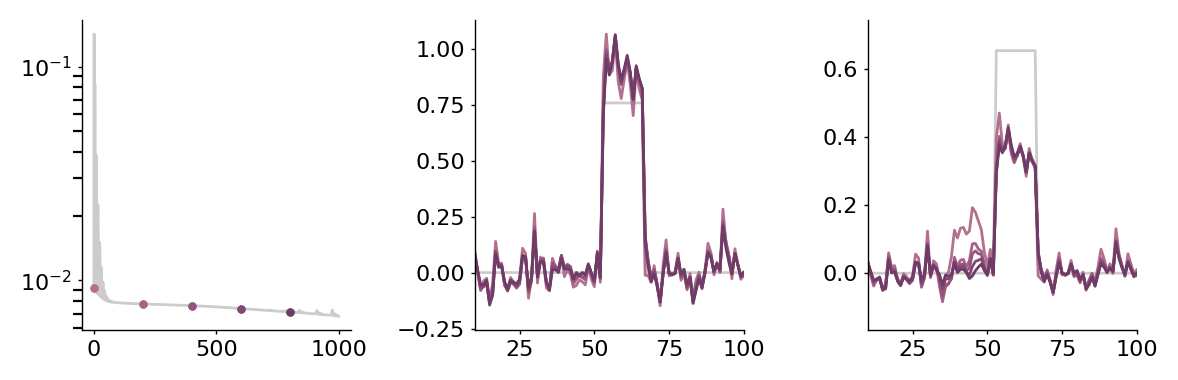

In [31]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y, start = 0)
for a in ax[1:]:
    a.set_xlim(10, 100)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

##### annealing

In [60]:
th.manual_seed(0)
rnn = ScriptBasicRNN(
    x.shape[-1], 1024, y.shape[-1], alpha=1, act=nn.Softplus(), bias=True
)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)
rnn.to(device)

opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=5e-5)
sched = optim.lr_scheduler.CyclicLR(
    opt, base_lr=1e-6, max_lr=1e-4, step_size_up=500, mode="triangular"
)
losses, yhats, lr_hist = rnns.fit_rnn(
    rnn,
    x_fast.to(device),
    y_fast.to(device),
    opt,
    n_steps=4000,
    return_h=False,
    lr=sched,
)

100%|██████████| 4000/4000 [01:00<00:00, 66.56it/s]


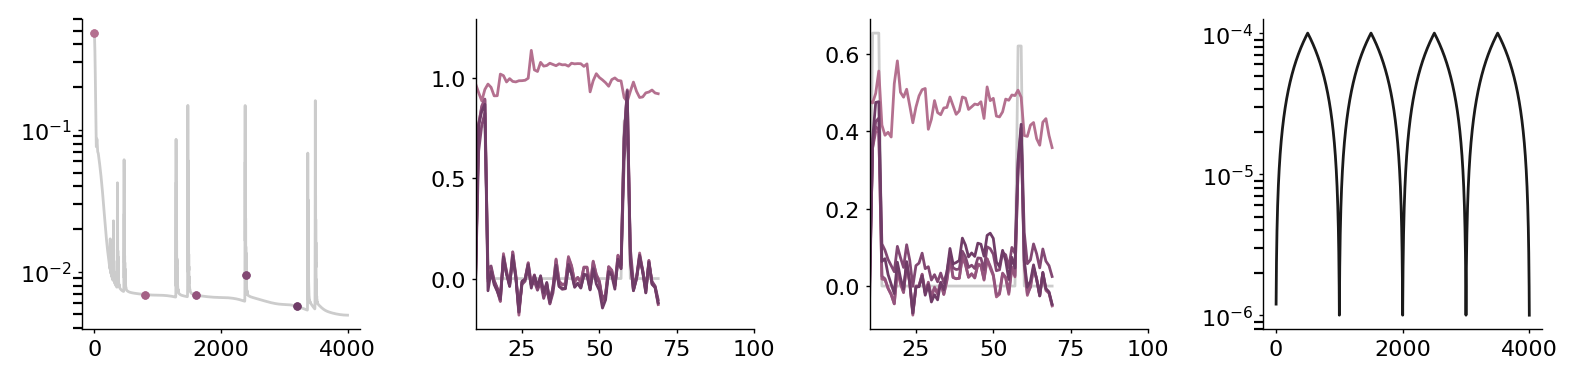

In [61]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y_fast, start = 0, lr = lr_hist)
for a in ax[1:3]:
    a.set_xlim(10, 100)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

In [56]:
th.manual_seed(0)
rnn = ScriptBasicRNN(
    x.shape[-1], 1024, y.shape[-1], alpha=1, act=nn.Softplus(), bias=True
)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)
rnn.to(device)

opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=5e-5)
losses, yhats = rnns.fit_rnn(
    rnn,
    x_fast.to(device),
    y_fast.to(device),
    opt,
    n_steps=4000,
    return_h=False,
)

100%|██████████| 4000/4000 [01:02<00:00, 64.11it/s]


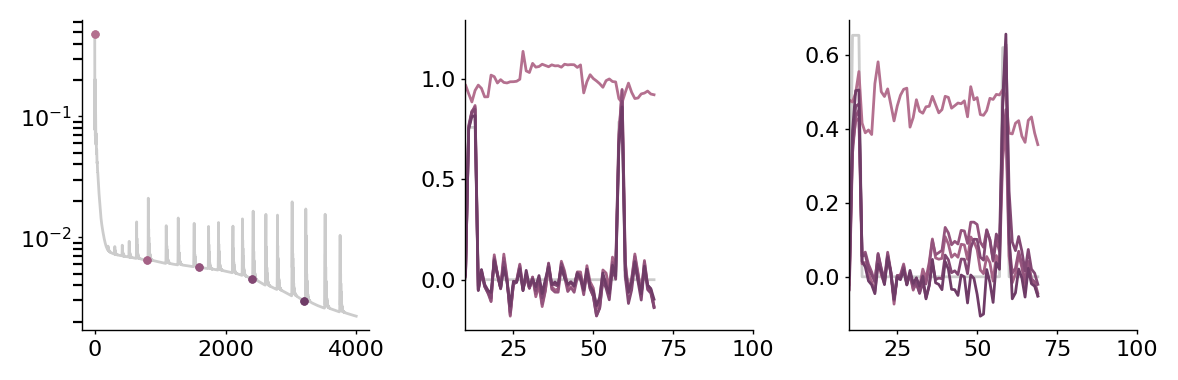

In [57]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y_fast, start = 0)
for a in ax[1:3]:
    a.set_xlim(10, 100)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

##### adam stability

In [62]:
th.manual_seed(0)
rnn = ScriptBasicRNN(
    x.shape[-1], 1024, y.shape[-1], alpha=1, act=nn.Softplus(), bias=True
)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)
rnn.to(device)

opt = optim.Adam(rnn.parameters(), amsgrad=True, eps = 1e-6, lr=5e-5)
losses, yhats = rnns.fit_rnn(
    rnn,
    x_fast.to(device),
    y_fast.to(device),
    opt,
    n_steps=4000,
    return_h=False,
)

100%|██████████| 4000/4000 [01:01<00:00, 65.02it/s]


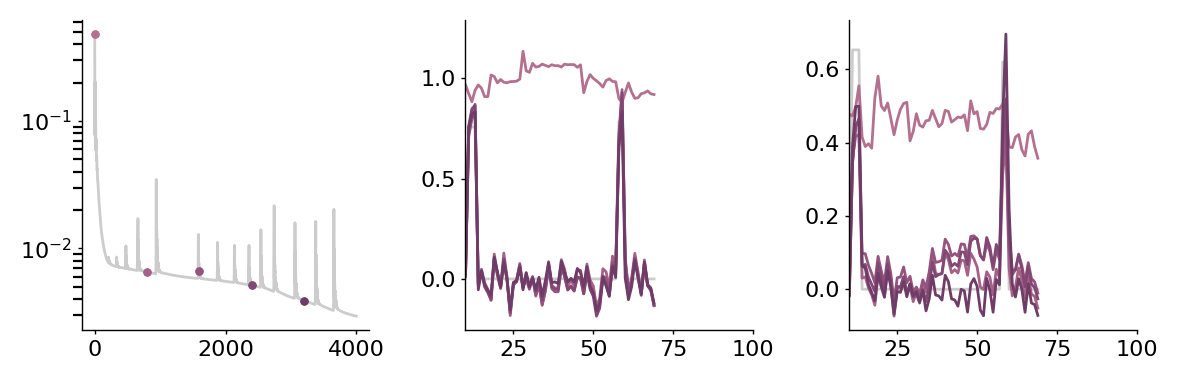

In [63]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y_fast, start = 0)
for a in ax[1:3]:
    a.set_xlim(10, 100)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

##### layernorm

In [64]:
class ScriptBasicRNN_LN(jit.ScriptModule):
    def __init__(
        self,
        nx=4,
        nh=10,
        ny=None,
        alpha=0.1,
        act=nn.Sigmoid(),
        h_bias=0,
        w_scale=1,
        act_ofs=0,
        bias = False,
    ):
        """
        Approximate dynamical RNN with negative weights.

        Parameters
        ----------
        alpha : float
            Step size divided by time constant, or equivalently a coefficient
            for convex combination of (in [0, 1]) $h_{t-1}$ and $f(h_{t-1})$ in
            the hidden state update rule, with `alpha` equal to 1 corresponding
            to a no-memory update.
        """
        nn.Module.__init__(self)
        rnns.init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)

        self.i2h = nn.Linear(self.nx, self.nh, bias=bias)
        self.h2h = nn.Linear(self.nh, self.nh, bias=bias)
        self.h2y = nn.Linear(self.nh, self.ny, bias=bias)
        self.hbn = nn.LayerNorm(self.nh, elementwise_affine=False)

    @jit.script_method
    def forward(self, x, h):
        h_norm = self.hbn(h)
        I = self.w_scale * self.h2h(h_norm) + self.i2h(x)
        fh = self.act(I + self.h_bias) + self.act_ofs
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(h_new)
        return y, h_new

    @jit.script_method
    def seq_forward(self, x, h):
        y = []
        hs = []
        for i in range(x.shape[1]):
            y_, h = self.forward(x[:, i], h)
            y.append(y_)
            hs.append(h)
        return th.stack(y, dim=1), th.stack(hs, dim=1)

    def init_hidden(self, batch_size, device = None):
        return th.zeros(batch_size, self.nh, device=device)

    def init_weights(self):
        pass

In [67]:
th.manual_seed(0)
rnn = ScriptBasicRNN_LN(
    x.shape[-1], 1024, y.shape[-1], alpha=1, act=nn.Softplus(), bias=True
)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)
rnn.to(device)

opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=5e-5)
losses, yhats = rnns.fit_rnn(
    rnn,
    x.to(device),
    y.to(device),
    opt,
    n_steps=4000,
    return_h=False,
)

100%|██████████| 4000/4000 [07:32<00:00,  8.85it/s]


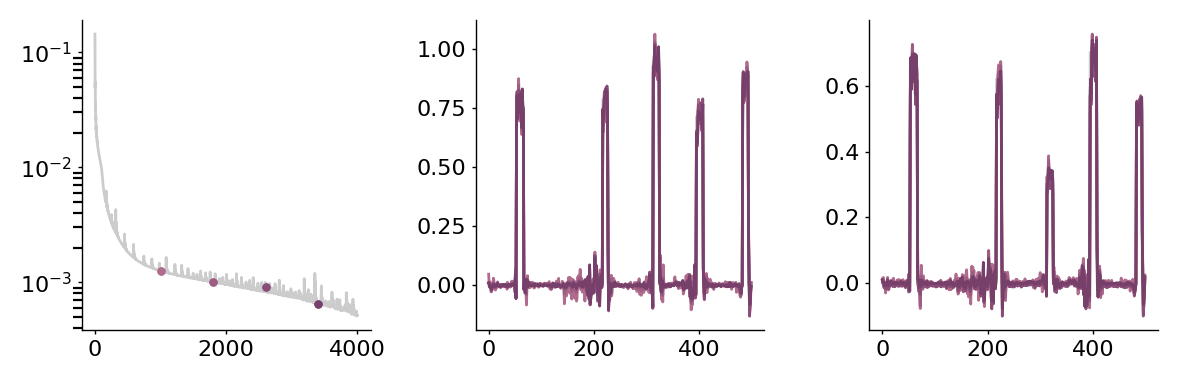

In [71]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y, start = 1000)
# for a in ax[1:3]:
    # a.set_xlim(10, 100)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

In [75]:
model_name = rnns.model_hash("driscoll-long-alpha1-n1024-ln")
out_dir = Path("/n/holylabs/LABS/bsabatini_lab/Users/kfox/loop/dynrn/models")
save_model(out_dir / model_name, rnn, x, y, periods, losses, yhats)

##### version of `BasicRNN_LN` that saves `seq_forward` also

In [6]:
class BasicRNN_LN(nn.Module):
    def __init__(
        self,
        nx=4,
        nh=10,
        ny=None,
        alpha=0.1,
        act=nn.Sigmoid(),
        h_bias=0,
        w_scale=1,
        act_ofs=0,
        bias = False,
    ):
        """
        Approximate dynamical RNN with negative weights.

        Parameters
        ----------
        alpha : float
            Step size divided by time constant, or equivalently a coefficient
            for convex combination of (in [0, 1]) $h_{t-1}$ and $f(h_{t-1})$ in
            the hidden state update rule, with `alpha` equal to 1 corresponding
            to a no-memory update.
        """
        nn.Module.__init__(self)
        rnns.init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)

        self.i2h = nn.Linear(self.nx, self.nh, bias=bias)
        self.h2h = nn.Linear(self.nh, self.nh, bias=bias)
        self.h2y = nn.Linear(self.nh, self.ny, bias=bias)
        self.hbn = nn.LayerNorm(self.nh, elementwise_affine=False)

    @jit.export
    def forward(self, x, h):
        h_norm = self.hbn(h)
        I = self.w_scale * self.h2h(h_norm) + self.i2h(x)
        fh = self.act(I + self.h_bias) + self.act_ofs
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(h_new)
        return y, h_new

    @jit.export
    def seq_forward(self, x, h):
        y = []
        hs = []
        for i in range(x.shape[1]):
            y_, h = self.forward(x[:, i], h)
            y.append(y_)
            hs.append(h)
        return th.stack(y, dim=1), th.stack(hs, dim=1)
    
    def init_hidden(self, batch_size, device = None):
        return th.zeros(batch_size, self.nh, device=device)

    def init_weights(self):
        pass

In [7]:
th.manual_seed(0)
rnn = BasicRNN_LN(
    x.shape[-1], 1024, y.shape[-1], alpha=1, act=nn.Softplus(), bias=True
)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)
rnn.to(device)

script_rnn = jit.script(rnn)

opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats = rnns.fit_rnn(
    script_rnn,
    x.to(device),
    y.to(device),
    opt,
    n_steps=5000,
    h_init = rnn.init_hidden(x.shape[0], device),
    return_h=False,
)

100%|██████████| 5000/5000 [10:13<00:00,  8.15it/s]


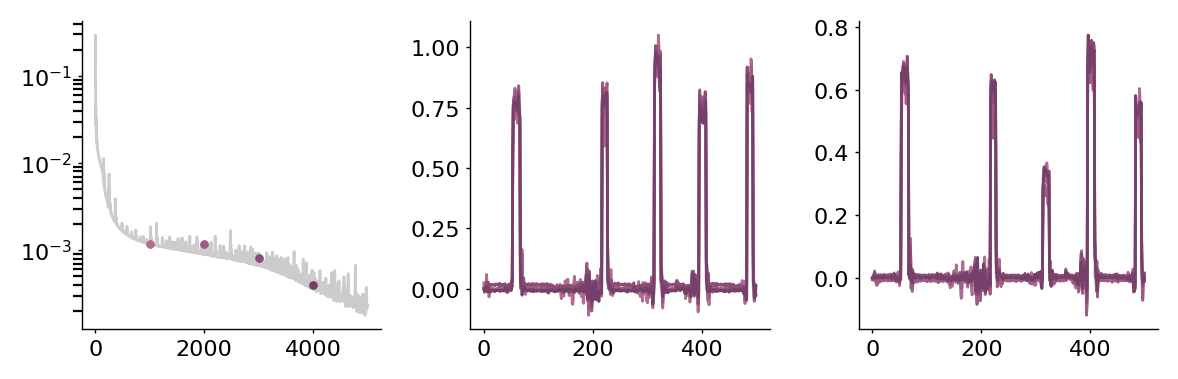

In [9]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y, start = 1000)
# for a in ax[1:3]:
    # a.set_xlim(10, 100)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

In [12]:
model_name = rnns.model_hash("driscoll-n1024")
out_dir = Path("/n/holylabs/LABS/bsabatini_lab/Users/kfox/loop/dynrn/task-models")
rnns.save_rnn(out_dir / model_name, script_rnn, x, y, losses, yhats, {"periods": periods})